This script is used to test the modules.

In [1]:
%matplotlib inline

import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import statistics

In [2]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath_ERAI = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
    datapath_ORAS4 = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ORAS4/postprocessing'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI,'model_daily_075_1979_2016_E_zonal_int.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath_ORAS4,'oras4_model_monthly_orca1_E_zonal_int.nc'))
    # extract time series from 1979 to 2014
    # from 20N - 90N
    AMET_ERAI_reverse = dataset_ERAI_AMET.variables['E'][:-2,:,:]/1000 # from Tera Watt to Peta Watt
    OMET_ORAS4 = dataset_ORAS4_OMET.variables['E'][21:,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:]    # from 1979 to 2014
    month_ORAS4 = dataset_ORAS4_OMET.variables['month'][:]
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_AMET_ERAI_reverse = dataset_ERAI_AMET.variables['latitude'][:]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    latitude_AMET_ERAI = latitude_AMET_ERAI_reverse[::-1]
    AMET_ERAI = AMET_ERAI_reverse[:,:,::-1]
    print (AMET_ERAI.shape)
    print (type(OMET_ORAS4))

*********************** extract variables *************************
(36, 12, 95)
<class 'numpy.ma.core.MaskedArray'>


In [3]:
    print ('*******************  interpolation for regression   **********************')
    # interpolate OMET on the latitude of AMET
    OMET_ORAS4_interp = np.zeros((len(year_ORAS4),len(month_ORAS4),len(latitude_AMET_ERAI)),dtype=float)
    for i in np.arange(len(year_ORAS4)):
        for j in np.arange(len(month_ORAS4)):
            ius = scipy.interpolate.interp1d(latitude_OMET_ORAS4, OMET_ORAS4[i,j,:], kind='slinear',
                                             bounds_error=False, fill_value=0.0)
            OMET_ORAS4_interp[i,j,:] = ius(latitude_AMET_ERAI.data)
    #print (OMET_ORAS4_interp)

*******************  interpolation for regression   **********************


*******************  postprocess with statistical tool  *********************
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
(373, 95)
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


(array([[ 0.0332327 ,  0.0313788 ,  0.02917476, ..., -0.58896718,
         -1.14288499,         nan],
        [ 0.03181334,  0.02980642,  0.02758744, ..., -0.57390709,
         -1.13623394,         nan],
        [ 0.0304001 ,  0.02826222,  0.02604869, ..., -0.55885011,
         -1.13025392,         nan],
        ...,
        [ 0.00853363,  0.00571451,  0.00539958, ..., -0.30763011,
         -0.87895375,         nan],
        [ 0.00730229,  0.00454449,  0.00437584, ..., -0.29588671,
         -0.85466801,         nan],
        [ 0.00585509,  0.00320216,  0.00320691, ..., -0.28357973,
         -0.82805178,         nan]]),
 array([[ 0.30210108,  0.28183389,  0.2528739 , ..., -0.43447688,
         -0.57452666,  0.        ],
        [ 0.29043333,  0.26857018,  0.23961613, ..., -0.42392986,
         -0.57151802,  0.        ],
        [ 0.27875282,  0.25556225,  0.22686085, ..., -0.41341747,
         -0.5688118 ,  0.        ],
        ...,
        [ 0.08139838,  0.05336855,  0.04817242, ..., -

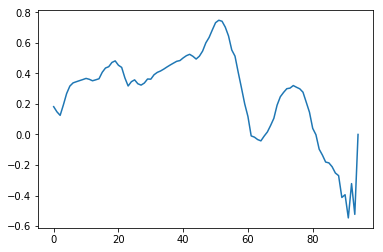

In [4]:
    print ('*******************  postprocess with statistical tool  *********************')
    stat_AMET_ERAI = statistics.operator(AMET_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.lowpass()
    stat_OMET_ORAS4 = statistics.operator(OMET_ORAS4_interp)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(obj='detrend')
    print (stat_OMET_ORAS4._lowpass.shape)
    a, b, c = statistics.operator.linearRegress(stat_AMET_ERAI._lowpass, stat_OMET_ORAS4._lowpass)
    plt.plot(b)
    statistics.operator.linearRegress(stat_AMET_ERAI._lowpass, stat_OMET_ORAS4._lowpass, lag=12)